In [43]:
import numpy as np
import matplotlib.pyplot as plt

## Input data generatin function

In [44]:
class Generate_Data():
    def generate_linear(n=100):
        pts = np.random.uniform(0, 1, (n, 2))
        inputs = []
        labels = []
        for pt in pts:
            inputs.append([pt[0], pt[1]])
            distance = (pt[0]-pt[1])/1.414
            if pt[0] > pt[1]:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(inputs), np.array(labels).reshape(n, 1)
    
    def generate_xor():
        inputs = []
        labels = []

        for i in range(11):
            inputs.append([0.1*i, 0.1*i])
            labels.append(0)

            if 0.1*i == 0.5:
                continue

            inputs.append([0.1*i, 1-0.1*i])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape(21, 1)

### Activationfunction

Sigmoid function and it's derivation function

In [45]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def derivative_sigmoid(y):
    """ The input must be the value passed through sigmoid function"""
    return y * (1-y)

ReLU funciton and it's derivation function

In [46]:
def relu(x):
    for i in range(len(x)):
        if x[i][0] < 0:
            x[i][0] = 0
    return x

def derivative_relu(x):
    d = np.zeros((x.shape[0], x.shape[1]))
    for i in range(len(x)):
        if x[i][0] >= 0:
            d[i][0] = 1
    return d

### Loss funciton: Binary cross entropy and it's derivative function

In [47]:
# add 1e-9 to avoid y_pred = 0 lead to math exception
def binary_cross_entropy(y, y_pred):
    return -(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))

def derivative_BCE(y, y_pred):
    return -(y/(y_pred + 1e-9) - (1-y)/(1-y_pred + 1e-9))

## Network: 
General DNN for 2 hidden layers and an output.

I choose sigmoid function to be the activation function, and select Gradient Decent to be the optimizer.

Default: training epochs is 1000, 
         learning rate is 0.01

In [48]:
class DNN:
    def __init__(self, hidden_size, num_epochs=1000, lr=0.01):
        self.num_epochs = num_epochs
        self.lr = lr
        self.losses = []

        # weight
        self.W = [np.random.rand(hidden_size[0], 2), np.random.rand(hidden_size[1], hidden_size[0]), np.random.rand(1, hidden_size[1])]
        # bias
        self.b = [np.random.rand(hidden_size[0], 1), np.random.rand(hidden_size[1], 1), np.random.rand(1, 1)]
        # before activation function
        self.z = [np.zeros((hidden_size[0], 1)), np.zeros((hidden_size[1], 1)), np.zeros((1, 1))]
        # after activation function
        self.a = [np.zeros((hidden_size[0], 1)), np.zeros((hidden_size[1], 1)), np.zeros((1, 1))]

    def forward(self, inputs):
        self.x = inputs.reshape(len(inputs), 1)         # dim: 2*1
        self.z[0] = self.W[0] @ self.x + self.b[0]      # dim: 10*1
        self.a[0] = sigmoid(self.z[0])                  # dim: 10*1
        self.z[1] = self.W[1] @ self.a[0] + self.b[1]   # dim: 10*1
        self.a[1] = sigmoid(self.z[1])                  # dim: 10*1
        self.z[2] = self.W[2] @ self.a[1] + self.b[2]   # dim: 1*1
        self.a[2] = sigmoid(self.z[2])                  # dim: 1*1
        return self.a[2]    # self.a[2] is y_pred
    
    def backward(self, y, y_pred):
        self.loss += binary_cross_entropy(y, y_pred)

        # compute the derivative of w2 and b2
        d_loss_a2 = derivative_BCE(y, y_pred)   # dim: 1*1
        d_a2_z2 = np.diag(derivative_sigmoid(self.a[2]).reshape(-1))    # dim: 1*1
        d_z2_w2 = self.a[1].T   # dim: 1*hidden_2_size
        d_loss_w2 = d_loss_a2 @ d_a2_z2 @ d_z2_w2   # dim: 1*hidden_2_size

        d_loss_b2 = d_loss_a2 @ d_a2_z2     # dim: 1*1, d_z2_b2=1

        # compute the derivative of w1 and b1
        d_z2_a1 = self.W[2]     # dim: 1*hidden_2_size
        d_a1_z1 = np.diag(derivative_sigmoid(self.a[1]).reshape(-1))    # dim: hidden_2_size*hidden_2_size
        d_z1_w1 = np.zeros((self.z[1].shape[0], self.W[1].shape[0]*self.W[1].shape[1]))     # dim: hidden_2_size*(hidden_2_size*hidden_1_size)
        m, n = self.z[1].shape[0], self.W[1].shape[1]   # m=hidden_2_size, n=hidden_1_size
        for i in range(m):
            d_z1_w1[i, i*n:(i+1)*n] = self.a[0].reshape(-1)
        d_loss_w1 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1 @ d_z1_w1   # dim: 1*(hidden_2_size*hidden_1_size)
        d_loss_w1 = d_loss_w1.reshape((m, n))   # dim: hidden_2_size*hidden_1_size

        d_loss_b1 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1     # dim: 1*hidden_2_size, d_z1_b1 is identity matrix
        d_loss_b1 = d_loss_b1.reshape((m, 1))   # dim: hidden_2_size*1

        # compute the derivative of w0 and b0
        d_z1_a0 = self.W[1]     # dim: hidden_2_size*hidden_1_size
        d_a0_z0 = np.diag(derivative_sigmoid(self.a[0]).reshape(-1))    # dim: hidden_1_size*hidden_1_size
        d_z0_w0 = np.zeros((self.z[0].shape[0], self.W[0].shape[0]*self.W[0].shape[1])) # dim: hidden_1_size*(hidden_1_size*input_size)
        m, n = self.z[0].shape[0], self.W[0].shape[1]   # m=hidden_1_size, n=input_size
        for i in range(m):
            d_z0_w0[i, i*n:(i+1)*n] = self.x.reshape(-1)
        d_loss_w0 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1 @ d_z1_a0 @ d_a0_z0 @ d_z0_w0   # dim: 1*(hidden_1_size*input_size)
        d_loss_w0 = d_loss_w0.reshape((m, n))

        d_loss_b0 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1 @ d_z1_a0 @ d_a0_z0     # dim: 1*hidden_1_size, d_z0_b0 is identity matrix
        d_loss_b0 = d_loss_b0.reshape((m, 1))   # dim: hidden_1_size*1


        # update weight
        self.W[0] -= self.lr * d_loss_w0
        self.W[1] -= self.lr * d_loss_w1
        self.W[2] -= self.lr * d_loss_w2

        self.b[0] -= self.lr * d_loss_b0
        self.b[1] -= self.lr * d_loss_b1
        self.b[2] -= self.lr * d_loss_b2
    
    def test(self, inputs, y):
        self.y_pred = []
        results = np.zeros(y.shape)
        for i in range(len(inputs)):
            results[i] = self.forward(inputs[i].T)  # the predict probabilities
            self.y_pred.append(np.round(results[i]))    # the predict class

        accuracy = sum(1 for i in range(len(y)) if y[i] == self.y_pred[i])  # accumulate thenumber of prediction correct
        return accuracy/len(inputs), results  
    
    def main(self, inputs, y):
        for epoch in range(self.num_epochs):
            self.loss = 0
            for i in range(len(inputs)):
                # forward propagation
                self.y_pred = self.forward(inputs[i].T)
                # compute loss, back propagation
                self.backward(y[i], self.y_pred)

            # print iteration time and loss each 200 epochs
            if epoch % 200 == 0:
                print(f'epoch {epoch} loss : {self.loss[0][0]/len(inputs)}')
            
            self.losses.append(self.loss.reshape(1))

        # Before terminal, test the model and show the prediction and accuracy
        np.set_printoptions(suppress=True)
        accuracy, results = self.test(inputs, y)
        print(f'----------Terminated----------\n{results}\naccuracy: {accuracy*100}%')
        


### Visualize

In [49]:
# show result function
def show_result(x, y, y_pred):
        plt.subplot(1, 2, 1)
        plt.title('Ground truth', fontsize=18)
        for i in range(len(x)):
            if y[i] == 0:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')

        plt.subplot(1, 2, 2)
        plt.title('Predict result', fontsize=18)
        for i in range(len(x)):
            if y_pred[i] == 0:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')

        plt.show()  

In [50]:
def loss_curve(loss, num_epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_epochs), loss)
    plt.title('loss_curve')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## XOR Data

In [51]:
x_xor, y_xor = Generate_Data.generate_xor()
# np.random.seed(36)
model_xor_dnn = DNN((20, 20), num_epochs=3000, lr=0.5)
model_xor_dnn.main(x_xor, y_xor)

epoch 0 loss : 5.004794772029904
epoch 200 loss : 0.7331482684074926
epoch 400 loss : 0.1954491545009682
epoch 600 loss : 0.19302998293107185
epoch 800 loss : 0.19220321894241965
epoch 1000 loss : 0.1867354664408546
epoch 1200 loss : 0.14712094482383117
epoch 1400 loss : 0.005618522200794321
epoch 1600 loss : 0.001504384699667157
epoch 1800 loss : 0.0009230837686612994
epoch 2000 loss : 0.0006690733353408958
epoch 2200 loss : 0.000525043295135865
epoch 2400 loss : 0.0004320436101299822
epoch 2600 loss : 0.00036698806199365387
epoch 2800 loss : 0.00031891701686056215
----------Terminated----------
[[0.00000025]
 [0.99997309]
 [0.00000039]
 [0.99997171]
 [0.00000096]
 [0.99996728]
 [0.00000588]
 [0.99994349]
 [0.00041375]
 [0.99791321]
 [0.00137212]
 [0.00008431]
 [0.99949896]
 [0.00019755]
 [0.99999724]
 [0.00026265]
 [0.99999434]
 [0.00028961]
 [0.99997876]
 [0.00030153]
 [0.99991461]]
accuracy: 100.0%


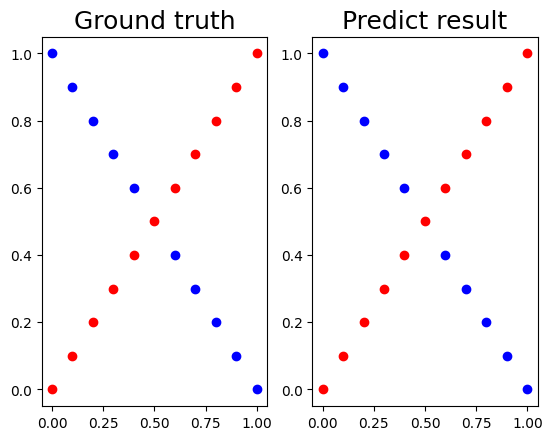

In [52]:
y_pred_xor_dnn = np.zeros(y_xor.shape)
for i in range(len(x_xor)):
    y_pred_xor_dnn[i] = np.round(model_xor_dnn.forward(x_xor[i].T))
show_result(x_xor, y_xor, y_pred_xor_dnn)

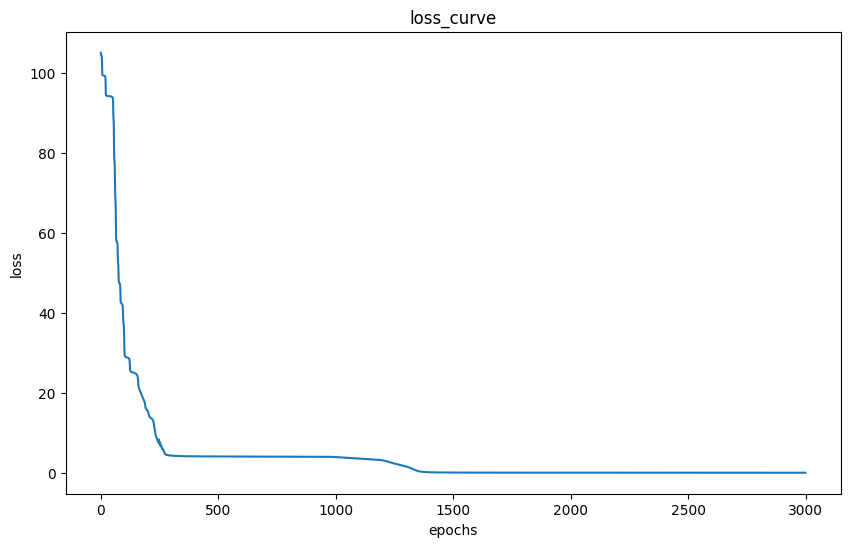

In [53]:
loss_curve(model_xor_dnn.losses, 3000)

## Linear Data

In [54]:
x_linear, y_linear = Generate_Data.generate_linear()

model_linear_dnn = DNN((10, 10), num_epochs=2000, lr=0.01)
model_linear_dnn.main(x_linear, y_linear)

epoch 0 loss : 1.6601813462903088
epoch 200 loss : 0.7010426477904289
epoch 400 loss : 0.7007407611045771
epoch 600 loss : 0.6998840639615129
epoch 800 loss : 0.6919443151259883
epoch 1000 loss : 0.22024359234563773
epoch 1200 loss : 0.07911377215548648
epoch 1400 loss : 0.049663422047238316
epoch 1600 loss : 0.037460772765896676
epoch 1800 loss : 0.030806509557701336
----------Terminated----------
[[0.00004602]
 [0.93535162]
 [0.99944557]
 [0.99993636]
 [0.00012804]
 [0.99968501]
 [0.99843713]
 [0.99992733]
 [0.00027129]
 [0.00013846]
 [0.29341465]
 [0.99133509]
 [0.99992445]
 [0.93135427]
 [0.99891546]
 [0.99947592]
 [0.99995666]
 [0.99977198]
 [0.00004509]
 [0.00005761]
 [0.99995784]
 [0.00005262]
 [0.99995777]
 [0.00004767]
 [0.53642267]
 [0.84587648]
 [0.99995817]
 [0.00010452]
 [0.99993959]
 [0.99995   ]
 [0.00043999]
 [0.00114106]
 [0.99651835]
 [0.99696249]
 [0.53337507]
 [0.00883602]
 [0.89453419]
 [0.00842632]
 [0.99995282]
 [0.99995128]
 [0.00004684]
 [0.99995858]
 [0.999957

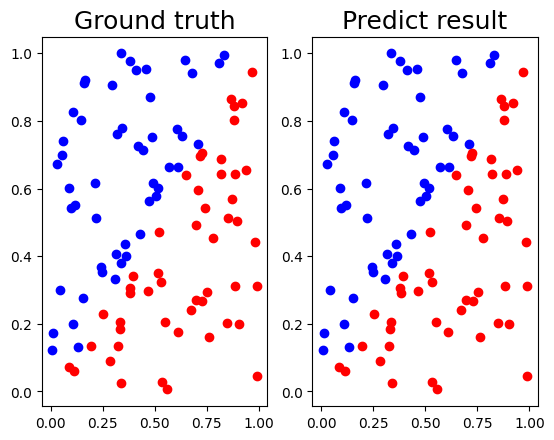

In [55]:
y_pred_linear_dnn = np.zeros(y_linear.shape)
for i in range(len(x_linear)):
    y_pred_linear_dnn[i] = np.round(model_linear_dnn.forward(x_linear[i].T))
show_result(x_linear, y_linear, y_pred_linear_dnn)

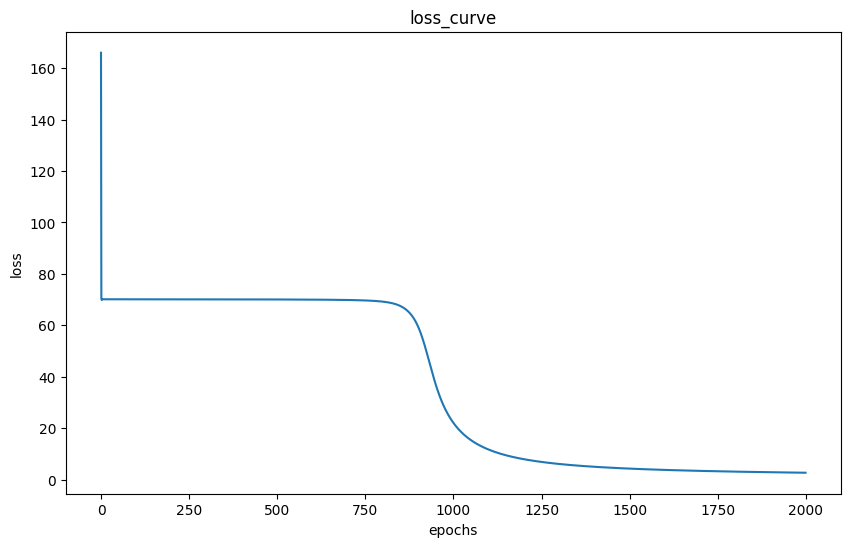

In [56]:
loss_curve(model_linear_dnn.losses, 2000)

## Bonus part

I use an cnn layer at first, and two dense layers after that. 
* kernel size: 3*1
* padding: zero padding
* stride: 1

I use relu in the first hidden layer and sigmoid in the second hidden layer and output layer to be activation function.

And the optimizer I choose Momentum.

In [57]:
class Bonus:
    def __init__(self, hidden_size, num_epochs=1000, lr=0.01):
        self.num_epochs = num_epochs
        self.lr = lr
        self.losses = []

        # 3*1 kernel
        self.kernel = []    
        for i in range(hidden_size[0]//2):  # Because the input size is 4*1([[0], [x1], [x2], [0]]^T), and the kernel size is 3*1, so if we want the hidden layer size is h, the kernel number need to set h/2
            self.kernel.append(np.random.rand(3, 1))    # kernel size: 3*1
        self.kernel = np.array(self.kernel).reshape(hidden_size[0]//2, 3, 1)

        # weight
        self.W = [np.random.rand(hidden_size[1], hidden_size[0]), np.random.rand(1, hidden_size[1])]
        # bias
        self.b = [np.random.rand(hidden_size[0], 1), np.random.rand(hidden_size[1], 1), np.random.rand(1, 1)]
        # before activation function
        self.z = [np.zeros((hidden_size[0], 1)), np.zeros((hidden_size[1], 1)), np.zeros((1, 1))]
        # after activation function
        self.a = [np.zeros((hidden_size[0], 1)), np.zeros((hidden_size[1], 1)), np.zeros((1, 1))]

        # the momentum update parameter
        self.v = [np.zeros((hidden_size[0]//2, 3, 1)), np.zeros((hidden_size[1], hidden_size[0])), np.zeros((1, hidden_size[1]))]

    # inputs data dot kernel and add bias
    def convolution(self, inputs):
        for i in range(len(self.kernel)):
            n = len(inputs) - self.kernel.shape[1] + 1  # len(inputs) - self.kernel.shape[1] + 1 is the convolution times of one kernel 
            for j in range(n): # stride = 1
                self.z[0][i*(n) + j] = np.sum(inputs[j:j+self.kernel.shape[1]] * self.kernel[i]) + self.b[0][i*(n) + j]

    def forward(self, inputs):
        input = np.zeros((len(inputs)+2, 1))    # dim: 4*1, zero-padding
        input[1:3] = inputs.reshape(len(inputs), 1) # input = [[0], [x1], [x2], [0]]
        self.x = input        # dim: 4*1

        self.convolution(self.x)                        # dim: 10*1
        self.a[0] = relu(self.z[0])                     # dim: 10*1
        self.z[1] = self.W[0] @ self.a[0] + self.b[1]   # dim: 10*1
        self.a[1] = sigmoid(self.z[1])                  # dim: 10*1
        self.z[2] = self.W[1] @ self.a[1] + self.b[2]   # dim: 1*1
        self.a[2] = sigmoid(self.z[2])                  # dim: 1*1
        return self.a[2]    # self.a[2] is y_pred
    
    def backward(self, y, y_pred):
        self.loss += binary_cross_entropy(y, y_pred)

        # compute the derivative of w1 and b2
        d_loss_a2 = derivative_BCE(y, y_pred)   # dim: 1*1
        d_a2_z2 = np.diag(derivative_sigmoid(self.a[2]).reshape(-1))    # dim: 1*1
        d_z2_w1 = self.a[1].T   # dim: 1*hidden_2_size
        d_loss_w1 = d_loss_a2 @ d_a2_z2 @ d_z2_w1   # dim: 1*hidden_2_size

        d_loss_b2 = d_loss_a2 @ d_a2_z2     # dim: 1*1, d_z2_b2=1

        # compute the derivative of w0 and b1
        d_z2_a1 = self.W[1]     # dim: 1*hidden_2_size
        d_a1_z1 = np.diag(derivative_sigmoid(self.a[1]).reshape(-1))    # dim: hidden_2_size*hidden_2_size
        d_z1_w0 = np.zeros((self.z[1].shape[0], self.W[0].shape[0]*self.W[0].shape[1]))     # dim: hidden_2_size*(hidden_2_size*hidden_1_size)
        m, n = self.z[1].shape[0], self.W[0].shape[1]   # m=hidden_2_size, n=hidden_1_size
        for i in range(m):
            d_z1_w0[i, i*n:(i+1)*n] = self.a[0].reshape(-1)
        d_loss_w0 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1 @ d_z1_w0   # dim: 1*(hidden_2_size*hidden_1_size)
        d_loss_w0 = d_loss_w0.reshape((m, n))   # dim: hidden_2_size*hidden_1_size

        d_loss_b1 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1     # dim: 1*hidden_2_size, d_z1_b1 is identity matrix
        d_loss_b1 = d_loss_b1.reshape((m, 1))   # dim: hidden_2_size*1

        # compute the derivative of cnn kernels and b0 
        d_z1_a0 = self.W[0]     # dim: hidden_2_size*hidden_1_size
        d_a0_z0 = np.diag(derivative_relu(self.a[0]).reshape(-1))    # dim: hidden_1_size*hidden_1_size
        d_z0_kernel = np.zeros((self.z[0].shape[0], self.kernel.shape[0]*self.kernel.shape[1])) # dim: hidden_1_size*(kernel_number*kernel_size)
        m, n = self.z[0].shape[0], self.kernel.shape[1]   # m=hidden_1_size, n=input_size
        for i in range(m):
            t = i//2
            if i%2 == 0:
                d_z0_kernel[i, t*n:(t+1)*n] = self.x.reshape(-1)[:3]
            else:
                d_z0_kernel[i, t*n:(t+1)*n] = self.x.reshape(-1)[1:]
        d_loss_kernel = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1 @ d_z1_a0 @ d_a0_z0 @ d_z0_kernel   # dim: 1*(kernel_number*kernel_size)
        d_loss_kernel = d_loss_kernel.reshape((self.kernel.shape[0], self.kernel.shape[1], self.kernel.shape[2]))

        d_loss_b0 = d_loss_a2 @ d_a2_z2 @ d_z2_a1 @ d_a1_z1 @ d_z1_a0 @ d_a0_z0     # dim: 1*hidden_1_size, d_z0_b0 is identity matrix
        d_loss_b0 = d_loss_b0.reshape((m, 1))   # dim: hidden_1_size*1

        # update weight, use momentum to be optimizer, set momentum factor to be 0.9
        self.v[0] = 0.9 * self.v[0] - self.lr * d_loss_kernel
        self.v[1] = 0.9 * self.v[1] - self.lr * d_loss_w0
        self.v[2] = 0.9 * self.v[2] - self.lr * d_loss_w1

        self.kernel += self.v[0]
        self.W[0] += self.v[1]
        self.W[1] += self.v[2]
        
        self.b[0] -= self.lr * d_loss_b0
        self.b[1] -= self.lr * d_loss_b1
        self.b[2] -= self.lr * d_loss_b2
    
    def test(self, inputs, y):
        self.y_pred = []
        results = np.zeros(y.shape)
        for i in range(len(inputs)):
            results[i] = self.forward(inputs[i].T)
            self.y_pred.append(np.round(results[i]))

        accuracy = sum(1 for i in range(len(y)) if y[i] == self.y_pred[i])  # accumulate thenumber of prediction correct

        return accuracy/len(inputs), results  
    
    def main(self, inputs, y):
        for epoch in range(self.num_epochs):
            self.loss = 0
            for i in range(len(inputs)):
                # forward propagation
                self.y_pred = self.forward(inputs[i].T)
                # compute loss, back propagation
                self.backward(y[i], self.y_pred)

            # print iteration time and loss each 100 epochs
            if epoch % 100 == 0:
                print(f'epoch {epoch} loss : {self.loss[0][0]/len(inputs)}')
            self.losses.append(self.loss.reshape(1))

        # Before terminal, test the model and show the prediction and accuracy
        np.set_printoptions(suppress=True)
        accuracy, results = self.test(inputs, y)
        print(f'{results}\naccuracy: {accuracy*100}%')
        


In [58]:
# x_xor, y_xor = Generate_Data.generate_xor()

model_xor_bonus = Bonus((20, 10), num_epochs=2000, lr=0.05)
model_xor_bonus.main(x_xor, y_xor)

epoch 0 loss : 1.1745767630515103
epoch 100 loss : 0.9336479161168117
epoch 200 loss : 0.00938346560756681
epoch 300 loss : 0.0032819037723756904
epoch 400 loss : 0.0019846528874634776
epoch 500 loss : 0.001419786301170103
epoch 600 loss : 0.0011038001163812502
epoch 700 loss : 0.0009028000441394056
epoch 800 loss : 0.0007637448250787864
epoch 900 loss : 0.0006618381413068414
epoch 1000 loss : 0.0005839461450401439
epoch 1100 loss : 0.0005224723472440338
epoch 1200 loss : 0.0004727184659722628
epoch 1300 loss : 0.00043162289738453495
epoch 1400 loss : 0.00039710519313494963
epoch 1500 loss : 0.0003677021051938813
epoch 1600 loss : 0.0003423555089613383
epoch 1700 loss : 0.0003202789446987425
epoch 1800 loss : 0.0003008775419737604
epoch 1900 loss : 0.00028369256549196943
[[0.0000036 ]
 [0.99960506]
 [0.00000065]
 [0.99960476]
 [0.00000066]
 [0.99960303]
 [0.00000376]
 [0.99959239]
 [0.00003992]
 [0.99946272]
 [0.00063491]
 [0.00048524]
 [0.9995322 ]
 [0.0004077 ]
 [0.99988287]
 [0.0003

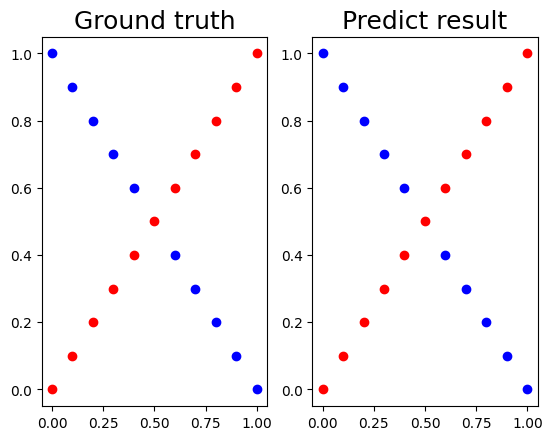

In [59]:
y_pred_xor_bonus = np.zeros(y_xor.shape)
for i in range(len(x_xor)):
    y_pred_xor_bonus[i] = np.round(model_xor_bonus.forward(x_xor[i].T))
show_result(x_xor, y_xor, y_pred_xor_bonus)

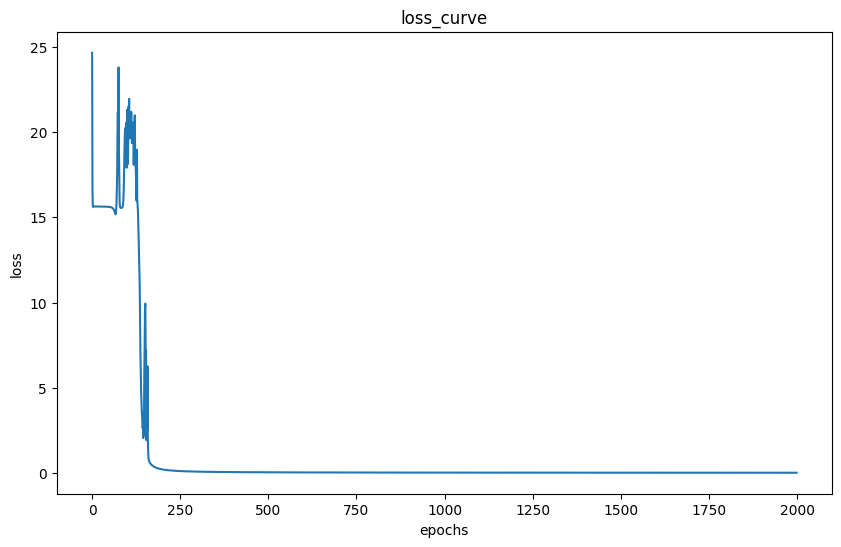

In [60]:
loss_curve(model_xor_bonus.losses, 2000)

In [61]:
# x_linear, y_linear = Generate_Data.generate_linear()

model_linear_bonus = Bonus((10, 10), num_epochs=1000, lr=0.01)
model_linear_bonus.main(x_linear, y_linear)

epoch 0 loss : 0.8305131016415589
epoch 100 loss : 0.018547204011160116
epoch 200 loss : 0.029182993051876806
epoch 300 loss : 0.0038027619922721616
epoch 400 loss : 0.002399995030906189
epoch 500 loss : 0.0016547542497268935
epoch 600 loss : 0.0012242204077956775
epoch 700 loss : 0.0009543381308433938
epoch 800 loss : 0.0007735311255286928
epoch 900 loss : 0.0006460979228320467
[[0.00005086]
 [0.9998687 ]
 [0.99995546]
 [0.99997082]
 [0.00002445]
 [0.99996138]
 [0.9999503 ]
 [0.99997025]
 [0.00003613]
 [0.00004588]
 [0.01993464]
 [0.99992046]
 [0.99996985]
 [0.99986633]
 [0.99994963]
 [0.99995751]
 [0.99997222]
 [0.99996264]
 [0.0000522 ]
 [0.0000393 ]
 [0.99997223]
 [0.00005496]
 [0.99997223]
 [0.00005567]
 [0.99736033]
 [0.99980742]
 [0.99997224]
 [0.00003491]
 [0.99997125]
 [0.99997187]
 [0.00001977]
 [0.00002356]
 [0.99993308]
 [0.99993695]
 [0.98167833]
 [0.0000283 ]
 [0.99983098]
 [0.00002271]
 [0.99997204]
 [0.99997198]
 [0.00005415]
 [0.99997224]
 [0.99997223]
 [0.99996968]
 [

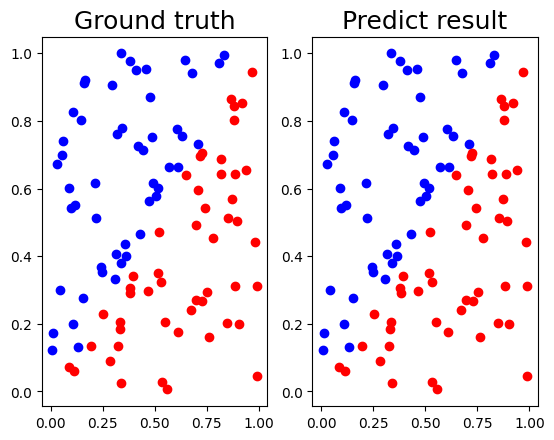

In [62]:
y_pred_linear_bonus = np.zeros(y_linear.shape)
for i in range(len(x_linear)):
    y_pred_linear_bonus[i] = np.round(model_linear_bonus.forward(x_linear[i].T))
show_result(x_linear, y_linear, y_pred_linear_bonus)

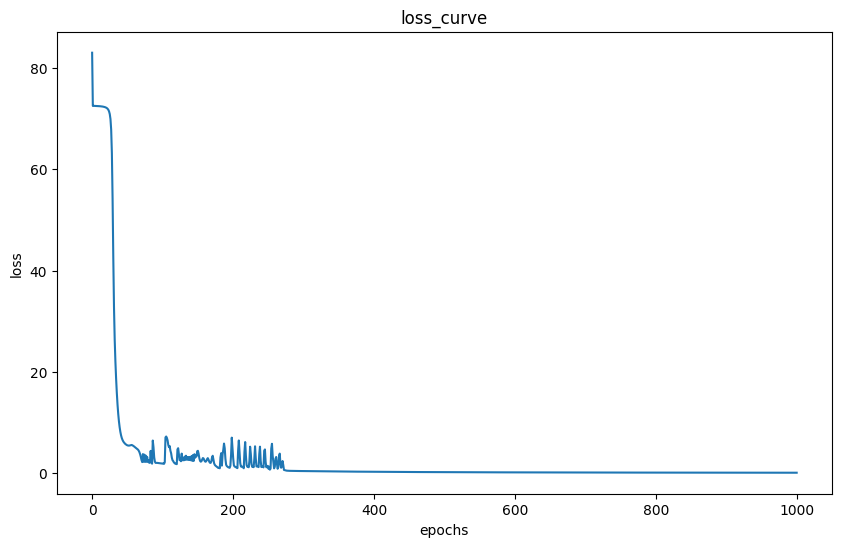

In [63]:
loss_curve(model_linear_bonus.losses, 1000)